# **Market Stock Prediction Using Batch Learning**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import plotly

In [2]:
data = pd.read_csv('BL_data_BTCUSDT.csv', index_col=1)

data.shape

(1000, 6)

In [3]:
data.head()

,Unnamed: 0,open,high,low,close,volume
date,,,,,,
2022-04-03,0,45810.99,47444.11,45530.92,46407.35,33394.67794
2022-04-04,1,46407.36,46890.71,45118.00,46580.51,44641.87514
2022-04-05,2,46580.50,47200.00,45353.81,45497.55,42192.74852
2022-04-06,3,45497.54,45507.14,43121.00,43170.47,60849.32936
2022-04-07,4,43170.47,43900.99,42727.35,43444.19,37396.54156


In [4]:
data.index.max(), data.index.min() 

('2024-12-27', '2022-04-03')

What we want to predict/forcast is the close price.

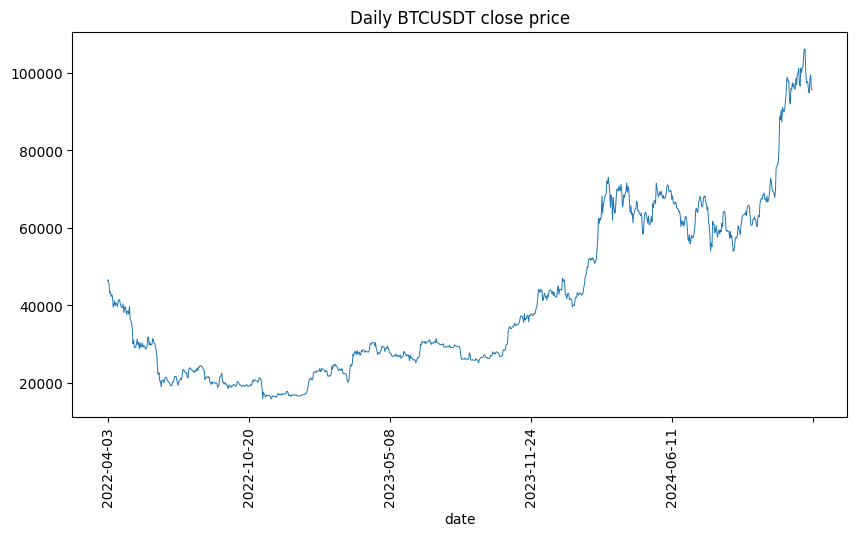

In [5]:
plt.figure(figsize=(10, 5))
data['close'].plot(linewidth=0.7)
plt.title("Daily BTCUSDT close price")
plt.xticks(rotation=90)
plt.show()


In [6]:
data['close'].describe()


count      1000.000000
mean      40779.622580
std       21436.476876
min       15781.290000
25%       23545.567500
50%       30291.730000
75%       60639.335000
max      106133.740000
Name: close, dtype: float64

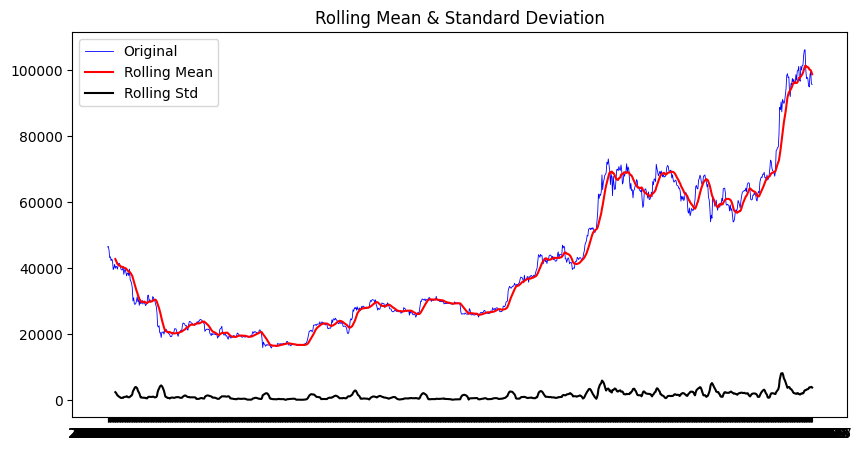

Results of Dickey-Fuller Test:
Test Statistic                   1.026381
p-value                          0.994537
#Lags Used                      20.000000
Number of Observations Used    979.000000
Critical Value (1%)             -3.437047
Critical Value (5%)             -2.864497
Critical Value (10%)            -2.568344
dtype: float64


In [7]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    # Plot rolling statistics:
    plt.figure(figsize=(10, 5))
    orig = plt.plot(timeseries, color='blue',label='Original', linewidth=0.6)
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(data['close'])


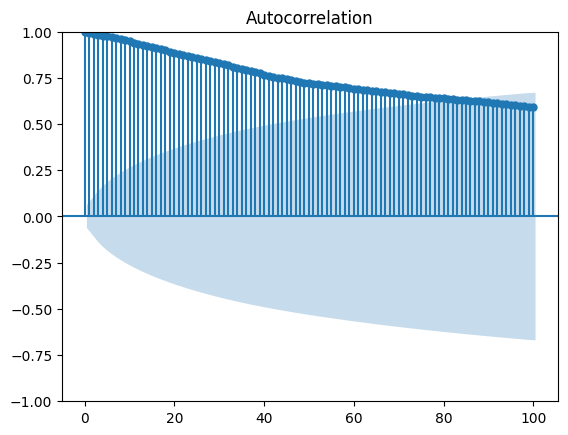

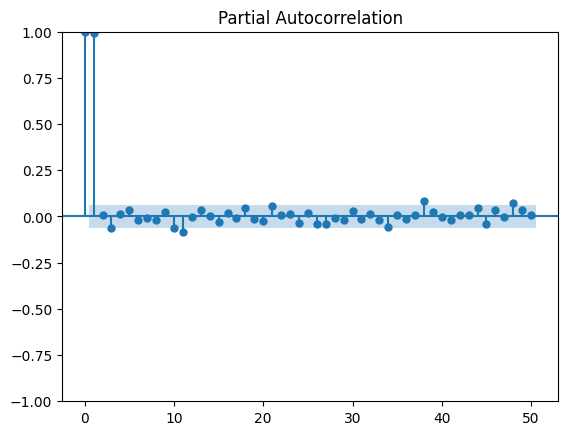

In [8]:
plot_acf(data['close'], lags=100)
plt.show()
plot_pacf(data['close'], lags=50)
plt.show()


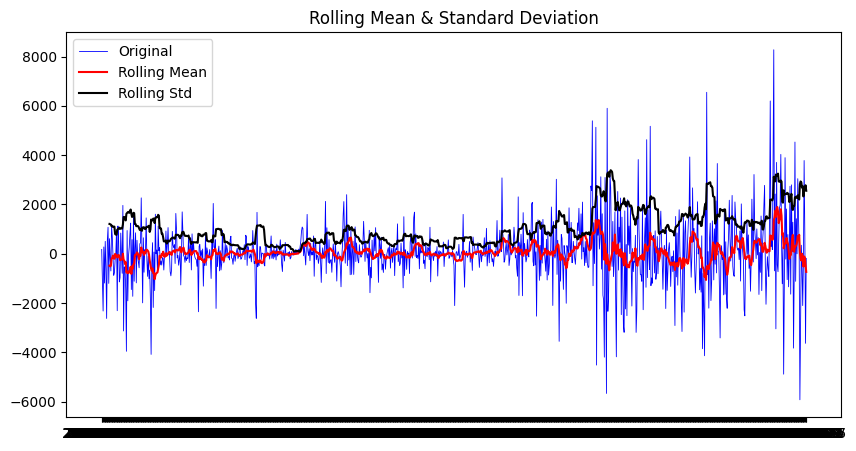

Results of Dickey-Fuller Test:
Test Statistic                -7.429520e+00
p-value                        6.415520e-11
#Lags Used                     1.900000e+01
Number of Observations Used    9.790000e+02
Critical Value (1%)           -3.437047e+00
Critical Value (5%)           -2.864497e+00
Critical Value (10%)          -2.568344e+00
dtype: float64


In [9]:
diff = data['close'].diff().dropna()
test_stationarity(diff)


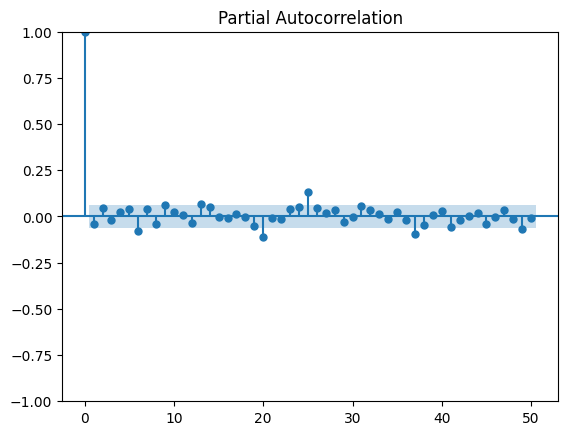

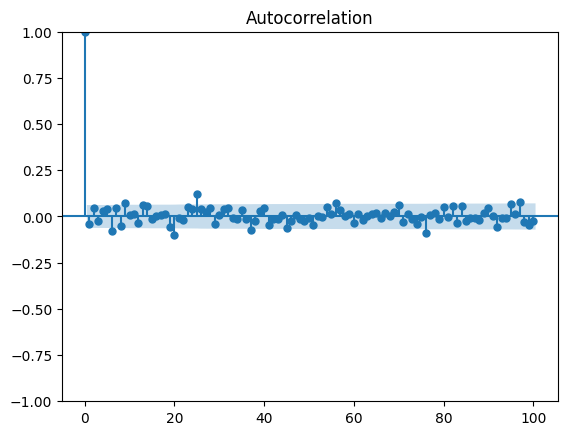

In [10]:
plot_pacf(diff, lags=50)
plt.show()
plot_acf(diff, lags=100)
plt.show()

So we will adopt a model : p = 1, d = 1, q = 1

In [25]:
y_train, y_test = data['close'][:int(len(data)*0.8)], data['close'][int(len(data)*0.8):]
x_train, x_test = data.drop('close', axis=1)[:int(len(data)*0.8)], data.drop('close', axis=1)[int(len(data)*0.8):]

In [32]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y_train.values, order=(1,0,1), exog= x_train.values)
model_fit = model.fit()

model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  800
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -5854.984
Date:                Sat, 28 Dec 2024   AIC                          11727.969
Time:                        12:50:29   BIC                          11770.130
Sample:                             0   HQIC                         11744.165
                                - 800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -28.3493     44.434     -0.638      0.523    -115.438      58.739
x1             0.2283      0.070      3.255      0.001       0.091       0.366
x2            -0.5524      0.012    -45.502      0.000      -0.576      -0.529
x3             0.8851      0.012     73.355      0.000       0.861       0.909
x4             0.6626      0.010     68.618      0.000       0.644       0.681
x5            -0.0002      0.000     -1.415      0.157      -0.000    6.23e-05
ar.L1          0.3478      0.250      1.394      0.163      -0.141       0.837
ma.L1         -0.4271      0.244     -1.751      0.080      -0.905       0.051
sigma2      1.323e+05      0.054   2.46e+06      0.000    1.32e+05    1.32e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               406.01
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.84   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.94e+21. Standard errors may be unstable.
"""

In [33]:
import plotly.graph_objects as go
import numpy as np

# PLOT PREDICTIONS 

fig_predictions = go.Figure()

# Real data
fig_predictions.add_trace(go.Scatter(
    y=data['close'], 
    mode='lines', 
    line=dict(color='black', width=1.3),
    name='Real'
))

# Predicted data
fitted_values = model_fit.fittedvalues
forecast_values = model_fit.forecast(steps=len(y_test), exog=x_test.values)
predicted = np.concatenate([fitted_values, forecast_values])
fig_predictions.add_trace(go.Scatter(
    y=predicted,
    mode='lines',
    line=dict(color='orange', width=1.3),
    name='Predicted'
))

# Layout settings
fig_predictions.update_layout(
    title='ARIMAX Model Forecasting of BTCUSDT Close Price',
    xaxis_title='Time',
    yaxis_title='Value',
    template='plotly_white',
    height=600,
    width=900
)
# divide the graph into two parts a left part for training data and a right part for testing data, fill the part with different colors
fig_predictions.add_shape(
    type="rect",
    x0=0,
    x1=len(y_train),
    y0=0,
    y1=data['close'].max(),
    line=dict(width=0),
    fillcolor="LightSkyBlue",
    opacity=0.1,
    layer="below", 
    name='Training phase'
)

fig_predictions.add_shape(
    type="rect",
    x0=len(y_train),
    x1=len(data),
    y0=0,
    y1=data['close'].max(),
    line=dict(width=0),
    fillcolor="LightCoral",
    opacity=0.1,
    layer="below", 
    name='Testing phase'
)

fig_predictions.show()
# PLOT RESIDUALS
fig_residuals = go.Figure()

# Residuals data
fig_residuals.add_trace(go.Scatter(
    y=model_fit.resid,
    mode='lines',
    line=dict(color='purple', width=0.7),
    name='Residuals'
))

# Layout settings
fig_residuals.update_layout(
    title='ARIMA Model Residuals',
    xaxis_title='Time',
    yaxis_title='Residuals',
    template='plotly_white',
    height=600,
    width=900
)

fig_residuals.show()

In [34]:
# metrics

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def metrics(y_true, y_pred):
    mse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, r2, mape

mse, mae, r2, mape = metrics(y_test, forecast_values)
print(f'RMSE: {mse}\nMAE: {mae}\nR2: {r2}\nMAPE: {mape}')


RMSE: 721.3520686394469
MAE: 531.3667117700821
R2: 0.9976638366139957
MAPE: 0.007549998435408522


In [24]:
# Use prophet model to predict the future price of BTCUSDT
from prophet import Prophet

data_prophet = data.reset_index()
data_prophet = data_prophet.rename(columns={'timestamp': 'ds', 'close': 'y'})
data_prophet = data_prophet[['ds', 'y']]
data_prophet.head()
